## Get Started with Projected Gradient Descent Attack

__Description__:

This notebook quickly demonstrates the use of the Projected Gradient Descent attack in code as part of Test & Evaluation of small benchmark datasets (MNIST and CIFAR-10). 
Key features:
- Attacks are demonstrated using parallel and non-parallel mode.
- Extracting attack metadata to determine the best performing attacks.
- Calculating clean and robust accuracy
- Calculating perturbation

__Intended Audience__: All T&E users

## Contents
1. Imports
2. Load CIFAR-10 model and data for classification
3. Load HuggingFace dataset for prediction
4. Load TorchVision dataset for prediction
5. Load TorchVision model for prediction
6. Define and run PGD attack
7. Extract Clean and Robust accuracy
8. JATIC Supported PGD attack
9. Extract Clean and Robust accuracy
10. JATIC Supported PGD Attack with HuggingFace dataset
11. Other Evasion Attacks
    - Carlini Attack
    - HopSkipJump (untargeted)
    - HopSkipJump (targeted)

### 1. Imports

In [1]:
from heart_library.estimators.classification.pytorch import JaticPyTorchClassifier
import numpy as np
import os
import torch
import matplotlib.pyplot as plt

from art.utils import load_dataset as load_dataset_art
from maite import load_dataset
from torchvision.transforms.functional import to_tensor

from maite import load_dataset
from maite.interop.torchvision import TorchVisionClassifier
from art.attacks.evasion import ProjectedGradientDescentPyTorch
from heart_library.metrics import AccuracyPerturbationMetric

from art.attacks.evasion.carlini import CarliniL0Method
from art.attacks.evasion.hop_skip_jump import HopSkipJump



### 2. Load CIFAR-10 model and data for classification

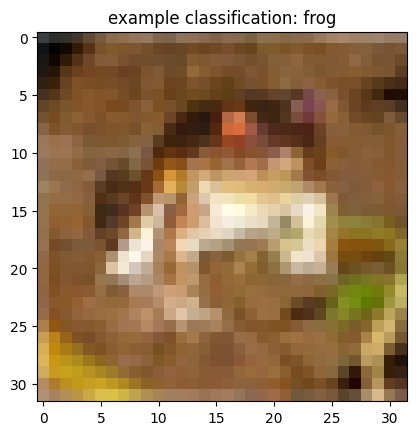

In [2]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset_art('cifar10')
i = 100
x_train = x_train[:100, :].transpose(0, 3, 1, 2).astype('float32')
x_test = x_test[:100, :].transpose(0, 3, 1, 2).astype('float32')
y_train = y_train[:100, :].astype('float32')
y_test = y_test[:100, :].astype('float32')

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

path = '../'

class Model(torch.nn.Module):
        """
        Create model for pytorch.
        Here the model does not use maxpooling. Needed for certification tests.
        """

        def __init__(self):
            super(Model, self).__init__()

            self.conv = torch.nn.Conv2d(
                in_channels=3, out_channels=16, kernel_size=(4, 4), dilation=(1, 1), padding=(0, 0), stride=(3, 3)
            )

            self.fullyconnected = torch.nn.Linear(in_features=1600, out_features=10)

            self.relu = torch.nn.ReLU()

            w_conv2d = np.load(
                os.path.join(
                    os.path.dirname(path),
                    "utils/resources/models",
                    "W_CONV2D_NO_MPOOL_CIFAR10.npy",
                )
            )
            b_conv2d = np.load(
                os.path.join(
                    os.path.dirname(path),
                    "utils/resources/models",
                    "B_CONV2D_NO_MPOOL_CIFAR10.npy",
                )
            )
            w_dense = np.load(
                os.path.join(
                    os.path.dirname(path),
                    "utils/resources/models",
                    "W_DENSE_NO_MPOOL_CIFAR10.npy",
                )
            )
            b_dense = np.load(
                os.path.join(
                    os.path.dirname(path),
                    "utils/resources/models",
                    "B_DENSE_NO_MPOOL_CIFAR10.npy",
                )
            )

            self.conv.weight = torch.nn.Parameter(torch.Tensor(w_conv2d))
            self.conv.bias = torch.nn.Parameter(torch.Tensor(b_conv2d))
            self.fullyconnected.weight = torch.nn.Parameter(torch.Tensor(w_dense))
            self.fullyconnected.bias = torch.nn.Parameter(torch.Tensor(b_dense))

        # pylint: disable=W0221
        # disable pylint because of API requirements for function
        def forward(self, x):
            """
            Forward function to evaluate the model
            :param x: Input to the model
            :return: Prediction of the model
            """
            x = self.conv(x)
            x = self.relu(x)
            x = x.reshape(-1, 1600)
            x = self.fullyconnected(x)
            x = torch.nn.functional.softmax(x, dim=1)
            return x

# Define the network
model = Model()

# Define a loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Get classifier
jptc = JaticPyTorchClassifier(
    model=model, loss=loss_fn, optimizer=optimizer, input_shape=(3, 32, 32), nb_classes=10, clip_values=(0, 1), labels=labels
)
plt.imshow(x_train[0].transpose(1,2,0))
_ = plt.title(f'example classification: {labels[np.argmax(jptc(x_train[[0]]).logits, axis=1)[0]]}')

### 3. Load HuggingFace dataset for prediction

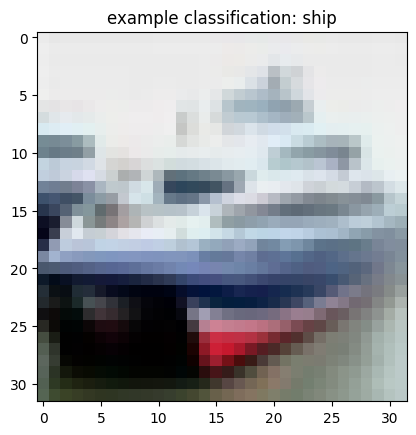

In [3]:
data = load_dataset(
    provider="huggingface",
    dataset_name="cifar10",
    task="image-classification",
    split="test"
)

data.set_transform(lambda x: {"image": to_tensor(x["image"]), "label": x["label"]})

plt.imshow(data[1]['image'].numpy().transpose(1, 2, 0))
_ = plt.title(f'example classification: {labels[np.argmax(jptc(data[1]).logits, axis=1)[0]]}')

### 4. Load TorchVision dataset for prediction

Files already downloaded and verified
Files already downloaded and verified


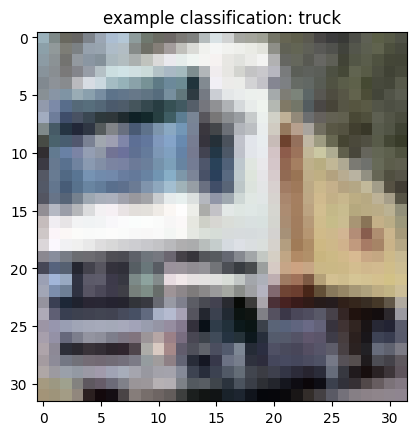

In [4]:
from torchvision.transforms.functional import to_tensor
from maite import load_dataset

data = load_dataset(
    provider="torchvision",
    dataset_name="CIFAR10",
    task="image-classification",
    split="test",
    root="~/.cache/torchvision/datasets",
    download=True
)

data.set_transform(lambda x: {"image": x["image"], "label": x["label"]})

plt.imshow(data[1]['image'])
_ = plt.title(f'example classification: {labels[np.argmax(jptc(data[1]).logits, axis=1)[0]]}')

### 5. Load TorchVision model for prediction

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


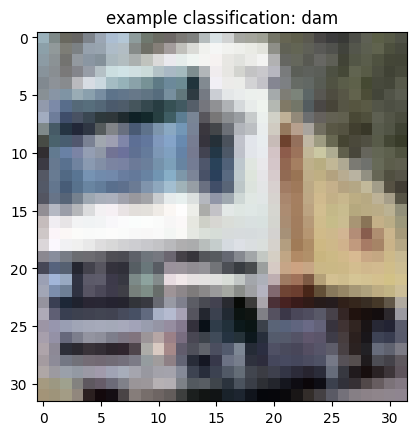

In [5]:
clf = TorchVisionClassifier.from_pretrained("resnet18")
jptc = JaticPyTorchClassifier(
    model=clf._model, loss=loss_fn, optimizer=optimizer, input_shape=(3, 32, 32), nb_classes=100, clip_values=(0, 1), labels=clf._labels
)

plt.imshow(data[1]['image'])
_ = plt.title(f'example classification: {jptc.get_labels()[np.argmax(jptc(data[1]).logits, axis=1)[0]]}')

### 6. Define and run PGD attack

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

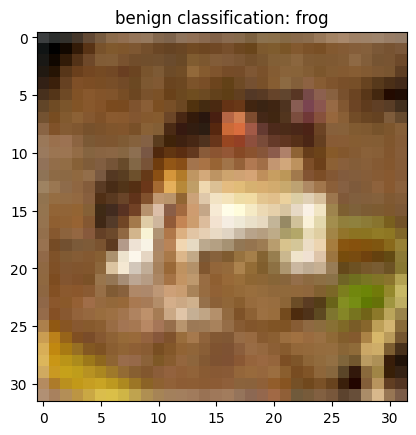

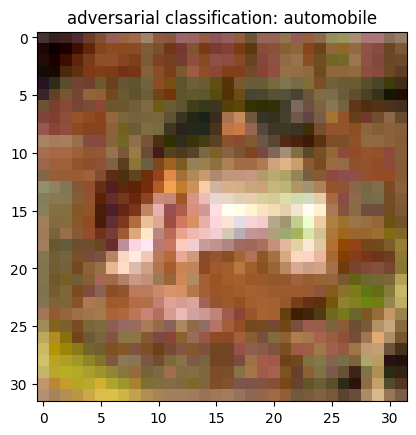

In [6]:
jptc = JaticPyTorchClassifier(
    model=model, loss=loss_fn, optimizer=optimizer, input_shape=(3, 32, 32), nb_classes=10, clip_values=(0, 1), labels=labels
)

attack = ProjectedGradientDescentPyTorch(estimator=jptc, max_iter=1000, eps=0.05, targeted=True)

x_adv = attack.generate(x=x_train[[0]], y=y_train[[4]])


plt.imshow(x_train[0].transpose(1,2,0))
_ = plt.title(f'benign classification: {labels[np.argmax(jptc(x_train[[0]]).logits, axis=1)[0]]}')
plt.show()


plt.imshow(x_adv[0].transpose(1,2,0))
_ = plt.title(f'adversarial classification: {labels[np.argmax(jptc(x_adv[[0]]).logits, axis=1)[0]]}')
plt.show()


### 7. Extract Clean and Robust accuracy

In [6]:
metric = AccuracyPerturbationMetric()
metric.update(jptc, jptc.device, x_train[[0]], x_adv, y_train[[0]])
clean_accuracy, robust_accuracy, perturbation_added = metric.compute()
print(f'Clean accuracy: {clean_accuracy}\nRobust Accuracy: {robust_accuracy}\nPerturbation: {perturbation_added:.2f}')

Clean accuracy: 1.0
Robust Accuracy: 0.0
Perturbation: 2.68


### 8. JATIC Suported PGD Attack

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

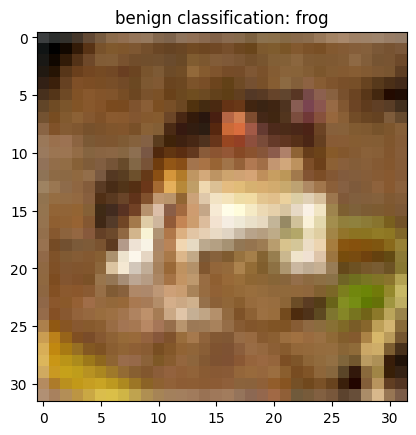

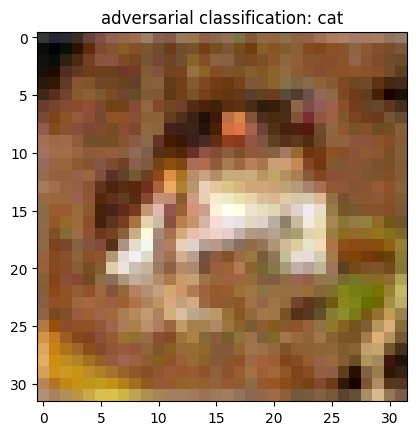

In [7]:
from art.attacks.evasion import ProjectedGradientDescentPyTorch
from heart_library.attacks.attack import JaticAttack, JaticEvasionAttackOutput

pgd_attack = ProjectedGradientDescentPyTorch(estimator=jptc, max_iter=1000, eps=0.03)
attack = JaticAttack(pgd_attack)

x_adv = attack.run_attack(data=x_train[[0]])
assert isinstance(x_adv, JaticEvasionAttackOutput)
x_adv = x_adv.adversarial_examples

plt.imshow(x_train[0].transpose(1,2,0))
_ = plt.title(f'benign classification: {labels[np.argmax(jptc(x_train[[0]]).logits, axis=1)[0]]}')
plt.show()


plt.imshow(x_adv[0].transpose(1,2,0))
_ = plt.title(f'adversarial classification: {labels[np.argmax(jptc(x_adv[[0]]).logits, axis=1)[0]]}')
plt.show()

### 9. Extract Clean and Robust accuracy

In [8]:
metric = AccuracyPerturbationMetric()
metric.update(jptc, jptc.device, x_train[[0]], x_adv, y_train[[0]])
clean_accuracy, robust_accuracy, perturbation_added = metric.compute()

print(f'Clean accuracy: {clean_accuracy}\nRobust Accuracy: {robust_accuracy}\nPerturbation: {perturbation_added:.2f}')

Clean accuracy: 1.0
Robust Accuracy: 0.0
Perturbation: 1.61


### 10. JATIC Supported PGD Attack with HuggingFace dataset
(pending update to deprecation of __task__)

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

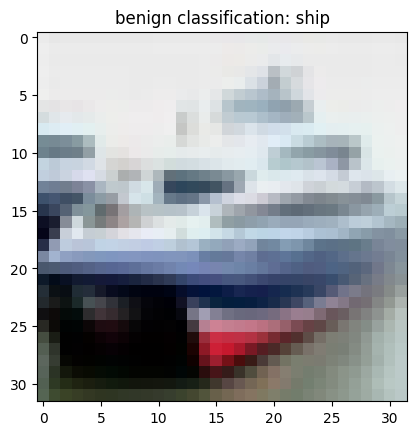

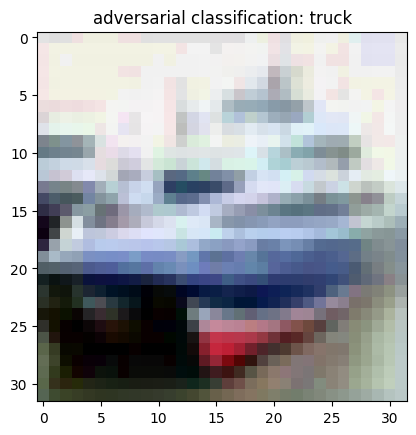

Clean accuracy: 1.0
Robust Accuracy: 0.0
Perturbation: 1.59


In [10]:
from heart_library.attacks.attack import JaticAttack, JaticEvasionAttackOutput
from maite import load_dataset

data = load_dataset(
    provider="huggingface",
    dataset_name="cifar10",
    task="image-classification",
    split="test"
)

pgd_attack = ProjectedGradientDescentPyTorch(estimator=jptc, max_iter=1000, eps=0.03)
attack = JaticAttack(pgd_attack)

x_adv = attack.run_attack(data=data[1]).adversarial_examples

plt.imshow(data[1]['image'])
_ = plt.title(f'benign classification: {labels[np.argmax(jptc(data[1]).logits)]}')
plt.show()


plt.imshow(x_adv[0].transpose(1,2,0))
_ = plt.title(f'adversarial classification: {labels[np.argmax(jptc(x_adv[0]).logits)]}')
plt.show()

metric = AccuracyPerturbationMetric()
metric.update(jptc, jptc.device, data[1], x_adv)
clean_accuracy, robust_accuracy, perturbation_added = metric.compute()
print(f'Clean accuracy: {clean_accuracy}\nRobust Accuracy: {robust_accuracy}\nPerturbation: {perturbation_added:.2f}')

### Other evasion attacks

#### Carlini Attack

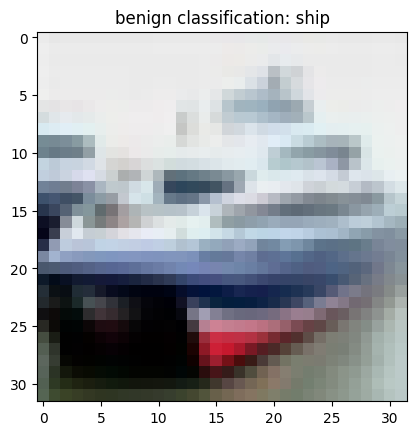

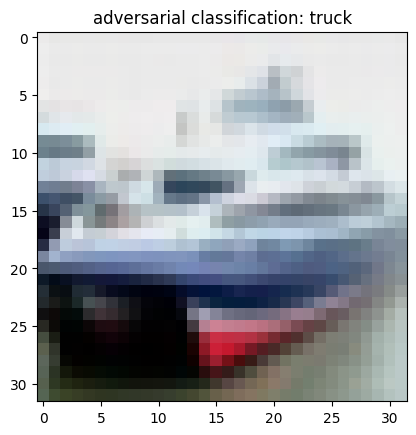

In [11]:
carlini_attack = CarliniL0Method(classifier=jptc)
attack = JaticAttack(carlini_attack)

x_adv = attack.run_attack(data=data[1])
assert isinstance(x_adv, JaticEvasionAttackOutput)
x_adv = x_adv.adversarial_examples

plt.imshow(data[1]['image'])
_ = plt.title(f'benign classification: {labels[np.argmax(jptc(data[1]).logits)]}')
plt.show()


plt.imshow(x_adv[0].transpose(1,2,0))
_ = plt.title(f'adversarial classification: {labels[np.argmax(jptc(x_adv[0]).logits)]}')
plt.show()

#### HopSkipJump (untargeted)

HopSkipJump:   0%|          | 0/1 [00:00<?, ?it/s]

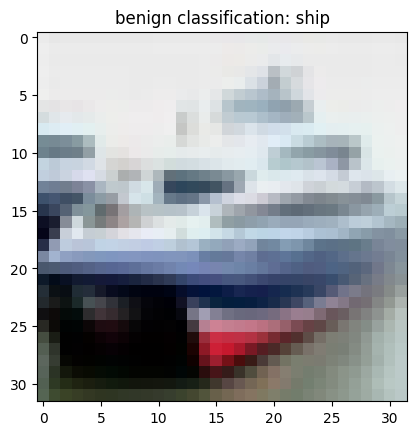

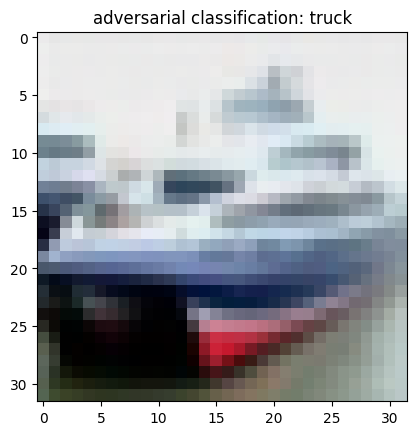

In [12]:
hsj_attack = HopSkipJump(classifier=jptc)
attack = JaticAttack(hsj_attack)

x_adv = attack.run_attack(data=data[1])
assert isinstance(x_adv, JaticEvasionAttackOutput)
x_adv = x_adv.adversarial_examples

plt.imshow(data[1]['image'])
_ = plt.title(f'benign classification: {labels[np.argmax(jptc(data[1]).logits)]}')
plt.show()


plt.imshow(x_adv[0].transpose(1,2,0))
_ = plt.title(f'adversarial classification: {labels[np.argmax(jptc(x_adv[0]).logits)]}')
plt.show()

HopSkipJump:   0%|          | 0/1 [00:00<?, ?it/s]

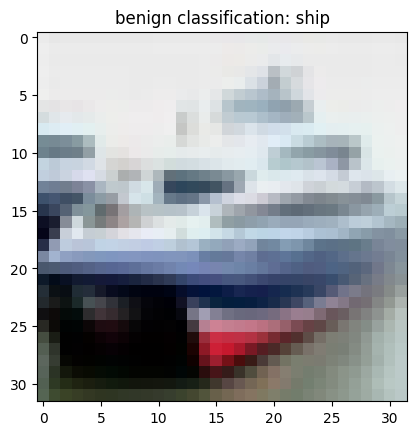

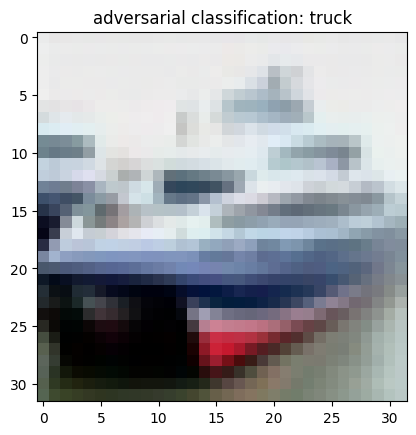

In [13]:
hsj_attack = HopSkipJump(classifier=jptc)
attack = JaticAttack(hsj_attack)

x_adv = attack.run_attack(data=data[1])
assert isinstance(x_adv, JaticEvasionAttackOutput)
x_adv = x_adv.adversarial_examples

plt.imshow(data[1]['image'])
_ = plt.title(f'benign classification: {labels[np.argmax(jptc(data[1]).logits)]}')
plt.show()


plt.imshow(x_adv[0].transpose(1,2,0))
_ = plt.title(f'adversarial classification: {labels[np.argmax(jptc(x_adv[0]).logits)]}')
plt.show()

#### HopSkipJump (targeted)
- HopSkipJump to force classifer to predict deer

HopSkipJump:   0%|          | 0/1 [00:00<?, ?it/s]

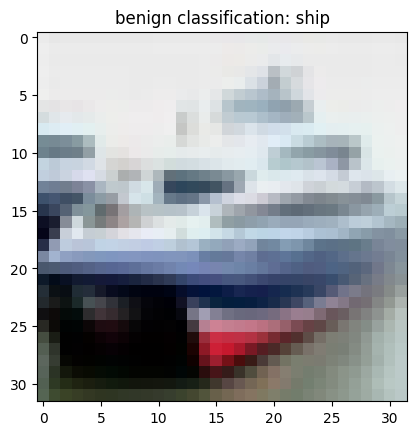

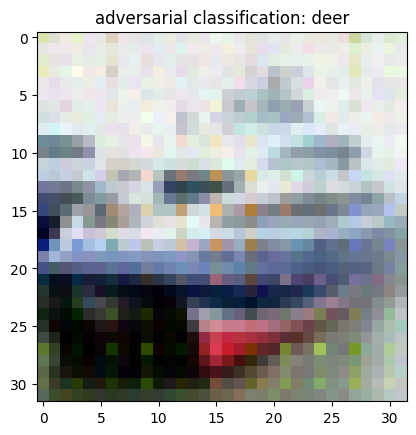

In [14]:
hsj_attack = HopSkipJump(classifier=jptc, targeted=True)
attack = JaticAttack(hsj_attack)

img = data[1] # image of ship
img['label'] = 4 # label for 'deer'

x_adv = attack.run_attack(data=img)
assert isinstance(x_adv, JaticEvasionAttackOutput)
x_adv = x_adv.adversarial_examples

plt.imshow(data[1]['image'])
_ = plt.title(f'benign classification: {labels[np.argmax(jptc(data[1]).logits)]}')
plt.show()


plt.imshow(x_adv[0].transpose(1,2,0))
_ = plt.title(f'adversarial classification: {labels[np.argmax(jptc(x_adv[0]).logits)]}')
plt.show()